# **IMAGE CLASSIFICATION** ***(COFFEE FRUITS)***

**Import Library**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy

**Hubungkan ke Dataset di Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset='/content/drive/MyDrive/DATASET_BUAH_KOPI'

train_folder = os.path.join(dataset,'Training')
validation_folder = os.path.join(dataset,'Validation')

**80% Training and 20% Validation Data**

In [7]:
#Training
def count_files(rootdir):
  for path in pathlib.Path(rootdir).iterdir():
    if path.is_dir():
      print("Terdapat " + str(len([name for name in os.listdir(path)\
      if os.path.isfile(os.path.join(path,name))])) + " Image Training Untuk Label " + \
      str(path.name))
  
count_files(os.path.join(train_folder))

Terdapat 280 Image Training Untuk Label Matang
Terdapat 280 Image Training Untuk Label Mentah
Terdapat 280 Image Training Untuk Label SetengahMatang


In [9]:
#Validation
def count_files(rootdir):
  for path in pathlib.Path(rootdir).iterdir():
    if path.is_dir():
      print("Terdapat " + str(len([name for name in os.listdir(path)\
      if os.path.isfile(os.path.join(path,name))])) + " Image Validation Untuk Label " + \
      str(path.name))
  
count_files(os.path.join(validation_folder))

Terdapat 70 Image Validation Untuk Label Matang
Terdapat 70 Image Validation Untuk Label Mentah
Terdapat 70 Image Validation Untuk Label SetengahMatang


**Visualisasi Dataset**

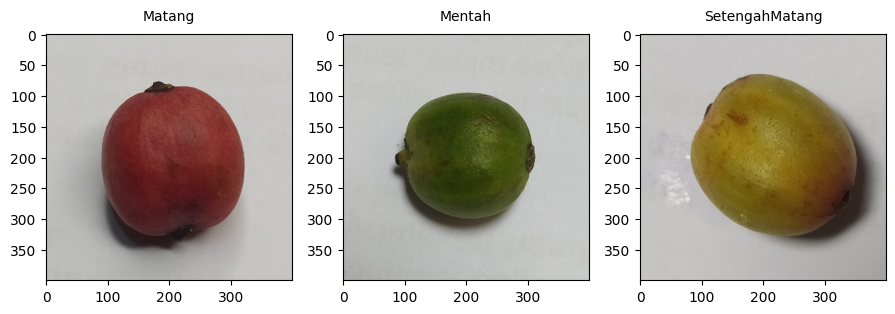

In [26]:
images = []

for label_folder in sorted(os.listdir(train_folder)):
    label_items = os.listdir(train_folder + '/' + label_folder)
    label_selected = np.random.choice(label_items)
    images.append(os.path.join(train_folder, label_folder, label_selected))

fig=plt.figure(1, figsize=(15, 10))

for subplot, image_ in enumerate(images):
  category=image_.split('/')[-2]
  imgs = plt.imread(image_)
  a,b,c=imgs.shape
  fig=plt.subplot(3, 5, subplot+1)
  fig.set_title(category, pad = 10, size=10)
  plt.imshow(imgs)

plt.tight_layout()

**Data Preprocessing** 

**ImageAugmentation**


In [27]:
train_datagen = ImageDataGenerator(
                rescale = 1./225, 
                rotation_range = 30, 
                horizontal_flip = True,
                vertical_flip=True, 
                shear_range = 0.3, 
                fill_mode ='nearest',
                brightness_range=(0.1, 0.9),
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                rescale = 1./225,
                rotation_range = 30,
                horizontal_flip = True,
                vertical_flip=True,
                shear_range = 0.3,
                fill_mode ='nearest',
                brightness_range=(0.1, 0.9),
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size =(224,224),
    color_mode = 'rgb',
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_folder,
    target_size =(224,224),
    color_mode = 'rgb',
    batch_size = 10,
    class_mode = 'categorical'
)

Found 840 images belonging to 3 classes.
Found 210 images belonging to 3 classes.


**Create Convolutional Neural Network (CNN) Model**

In [29]:
model_coffee = tf.keras.models.Sequential([
#Convolution layer    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

 #Fully Connected layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') #multiclass
])

In [30]:
model_coffee.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [31]:
#tampilkan semua layer
for i, layer in enumerate(model_coffee.layers):
    print(i, layer.name)

0 conv2d
1 max_pooling2d
2 conv2d_1
3 max_pooling2d_1
4 conv2d_2
5 max_pooling2d_2
6 flatten
7 dropout
8 dense
9 dense_1


In [32]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print('\nAkurasi sudah mencapai 99%')
      self.model.stop_training = True

callbacks =myCallback()

In [33]:
model_coffee.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history_coffee = model_coffee.fit(train_generator,
                            steps_per_epoch=15,
                            epochs=10, 
                            validation_data = val_generator, 
                            verbose = 1,
                            callbacks = [callbacks]
)

Epoch 1/10
15/15 [==============================] - 83s 6s/step - loss: 1.4929 - accuracy: 0.3600 - val_loss: 1.0702 - val_accuracy: 0.3333
Epoch 2/10
15/15 [==============================] - 40s 3s/step - loss: 0.9311 - accuracy: 0.5533 - val_loss: 0.7364 - val_accuracy: 0.6524
Epoch 3/10
15/15 [==============================] - 29s 2s/step - loss: 0.6927 - accuracy: 0.6733 - val_loss: 0.4424 - val_accuracy: 0.8524
Epoch 4/10
15/15 [==============================] - 29s 2s/step - loss: 0.3851 - accuracy: 0.8333 - val_loss: 0.3494 - val_accuracy: 0.9095
Epoch 5/10
15/15 [==============================] - 39s 3s/step - loss: 0.3226 - accuracy: 0.8600 - val_loss: 0.1830 - val_accuracy: 0.9333
Epoch 6/10
15/15 [==============================] - 28s 2s/step - loss: 0.0855 - accuracy: 0.9533 - val_loss: 0.2201 - val_accuracy: 0.9095
Epoch 7/10
15/15 [==============================] - 28s 2s/step - loss: 0.1371 - accuracy: 0.9467 - val_loss: 0.0666 - val_accuracy: 0.9810
Epoch 8/10
15/15 [==

**Visualisasi Plot Model CNN**

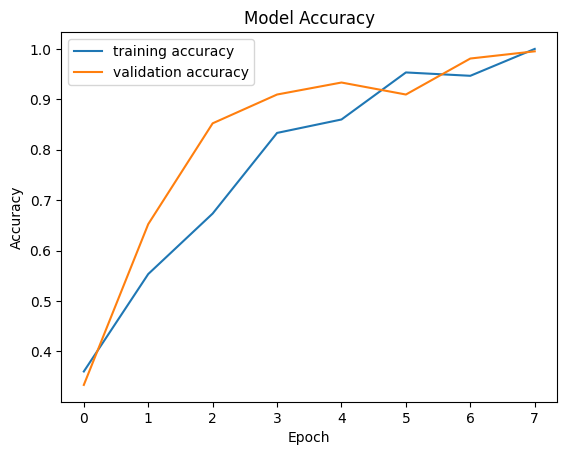

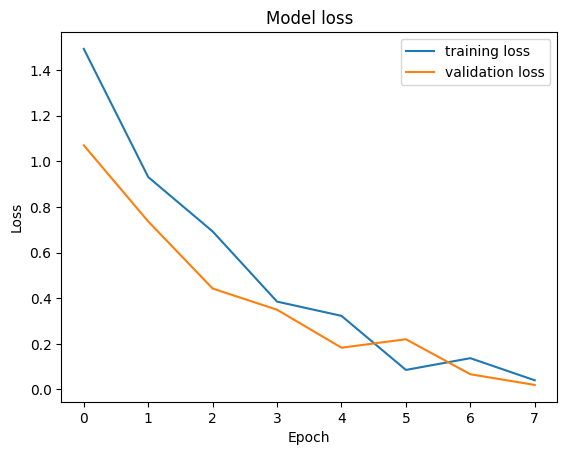

In [35]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label='validation accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'], label="training loss")
  plt.plot(history.history['val_loss'], label='validation loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.show()
  
plot_accuracy(history_coffee)
plot_loss(history_coffee)

In [36]:
valid_loss, valid_accuracy = model_coffee.evaluate(val_generator)

21/21 [==============================] - 9s 401ms/step - loss: 0.0187 - accuracy: 1.0000


In [37]:
print("Accuracy model CNN: {}".format(valid_accuracy))

Accuracy model CNN: 1.0


**Prediksi Image**

In [38]:
category = {
    0:"Matang", 1:"Mentah", 2:"Setengah Matang"
}

def predict_image(filename, model):
  img_ = image.load_img(filename, target_size=(224,224))
  img_array = image.img_to_array(img_)
  img_processed = np.expand_dims(img_array, axis=0)
  img_processed /= 255.

  prediction = model.predict(img_processed)
  index = np.argmax(prediction)

  plt.title("Prediction is {}".format(category[index]))
  plt.imshow(img_array)


**Mencoba Prediksi 10 Gambar**

1/1 [==============================] - 0s 140ms/step


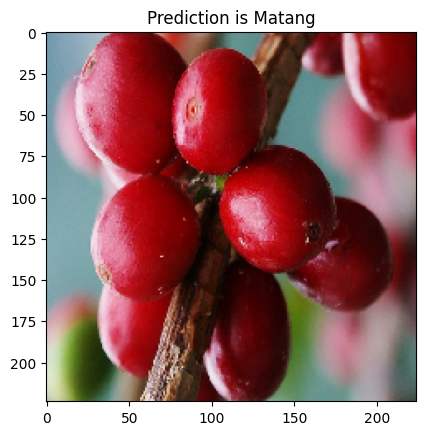

In [39]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/93.png", model_coffee)

1/1 [==============================] - 0s 44ms/step


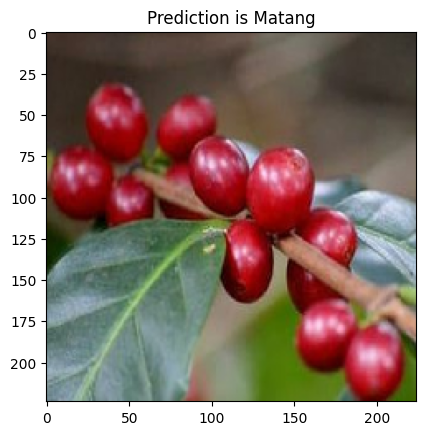

In [40]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/182.png", model_coffee)

1/1 [==============================] - 0s 44ms/step


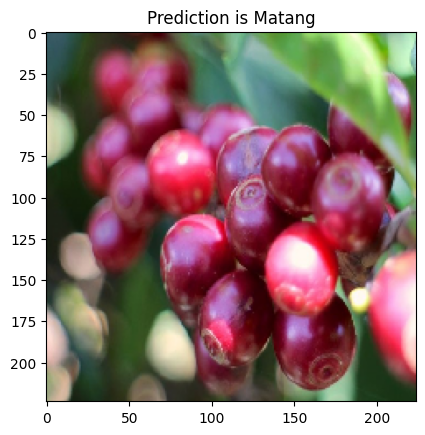

In [41]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/135.png", model_coffee)

1/1 [==============================] - 0s 46ms/step


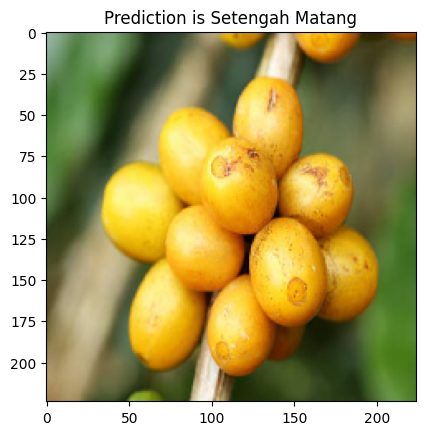

In [42]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/155.png", model_coffee)

1/1 [==============================] - 0s 351ms/step


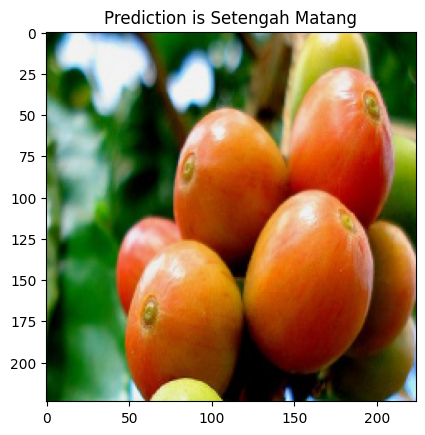

In [43]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/167.png", model_coffee)

1/1 [==============================] - 0s 45ms/step


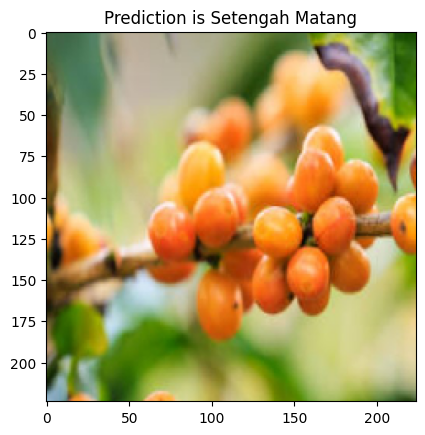

In [44]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/157.png", model_coffee)

1/1 [==============================] - 0s 71ms/step


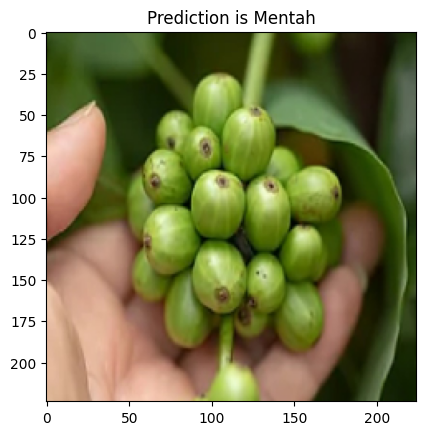

In [45]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/276.jpeg", model_coffee)

1/1 [==============================] - 0s 49ms/step


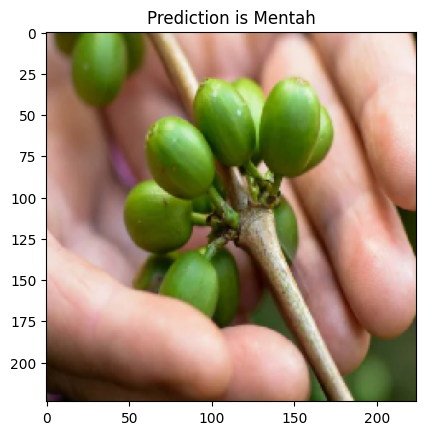

In [46]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/278.jpeg", model_coffee)

1/1 [==============================] - 0s 48ms/step


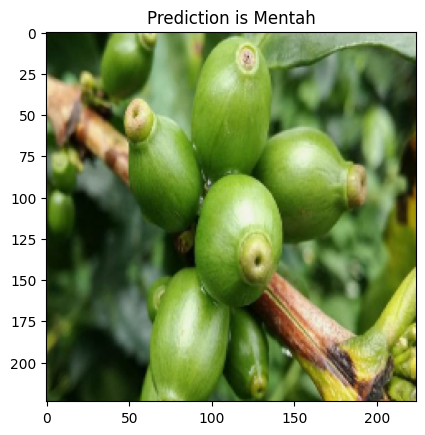

In [47]:
predict_image("/content/drive/MyDrive/DATASET_BUAH_KOPI/Testing/279.jpeg", model_coffee)

Saving 139.png to 139.png
1/1 [==============================] - 0s 43ms/step
139.png
Matang


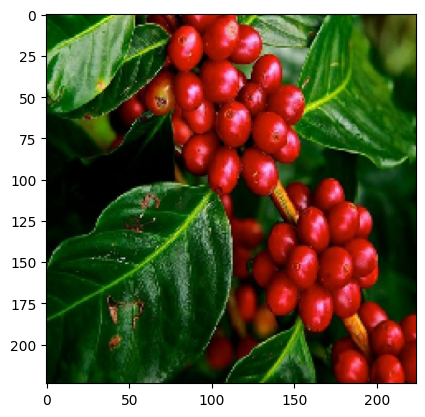

In [53]:
#Prediksi gambar baru
from google.colab import files
from keras.preprocessing import image
import keras.utils as image
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn 
  gambar = image.load_img(path, target_size =(224,224))
  imgplot = plt.imshow(gambar)
  x = image.img_to_array(gambar)
  x = np.expand_dims(x, axis=0)

  gambar_prediksi = np.vstack([x])
  classes = model_coffee.predict(gambar_prediksi, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('Matang')
  elif classes[0,1]!=0:
    print('Mentah')
  else:
    print('Setengah Matang')

**Save Model h5**

In [54]:
#Simpan model akhir
model_coffee.save("model_DCoffee_Classification.h5")
tf.keras.models.save_model(model_coffee,'model_DCoffee_Classification.hdf5')

**Save Model Json**

In [55]:
model_DCoffee_json = model_coffee.to_json()
with open("model_Dcoffee_Classification_json", "w") as file_json:
    file_json.write(model_DCoffee_json)